# Background, motivation and set up

**Objective**: Compare attributions using integrated gradients and activation patching, and investigate the discrepancies between the two methods.

**Motivation**:

- Understand when and why do IG and AP disagree: e.g. methodological limitations, or suitability to model tasks, etc.
- Investigate if discrepancies help uncover different hidden model behaviours
- Understand when and why linear approximations to activation patching fail
- Investigate limitations of using activation patching for evaluations: if results are different because of other unknown factors (not just because the method evaluated is "incorrect")

**Set-up**:

We load the transformer model GPT2-Small, which has 12 layers, 12 attention heads per layer, embedding size 768 and 4 x 768 = 3,072 neurons in each feed-forward layer. We use GPT2-Small because 1) it is a relatively small transformer model which has comparable behaviour to larger SOTA models, and 2) there is a lot of interpretability literature which focuses on circuits in this model.

In [1]:
import torch
import numpy as np

from captum.attr import LayerIntegratedGradients

from transformer_lens.utils import get_act_name, get_device
from transformer_lens import ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Save GPU memory, as this notebook focuses on model inference not training
torch.set_grad_enabled(False)

device = get_device()
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

Loaded pretrained model gpt2-small into HookedTransformer


# Attribution for GPT2-Small

We scale up our earlier experiments to implement integrated gradients and activation patching on a larger transformer model. We use the same counterfactual inputs, based on the Indirect Object Identification task.

In [3]:
#| output: true

clean_prompt = "After John and Mary went to the store, Mary gave a bottle of milk to"
corrupted_prompt = "After John and Mary went to the store, John gave a bottle of milk to"

clean_input = model.to_tokens(clean_prompt)
corrupted_input = model.to_tokens(corrupted_prompt)

def logits_to_logit_diff(logits, correct_answer=" John", incorrect_answer=" Mary"):
    # model.to_single_token maps a string value of a single token to the token index for that token
    correct_index = model.to_single_token(correct_answer)
    incorrect_index = model.to_single_token(incorrect_answer)
    return logits[0, -1, correct_index] - logits[0, -1, incorrect_index]

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

clean_logits, clean_cache = model.run_with_cache(clean_input)
clean_logit_diff = logits_to_logit_diff(clean_logits)
print(f"Clean logit difference: {clean_logit_diff.item():.3f}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_input)
corrupted_logit_diff = logits_to_logit_diff(corrupted_logits)
print(f"Corrupted logit difference: {corrupted_logit_diff.item():.3f}")

Clean logit difference: 4.276
Corrupted logit difference: -2.738


## Integrated Gradients

In [4]:
def run_from_layer_fn(x, original_input, prev_layer):
    # Force the layer before the target layer to output the given values, i.e. pass the given input into the target layer
    # original_input value does not matter; useful to keep shapes nice, but its activations will be overwritten
    logits = model.run_with_hooks(
        original_input,
        fwd_hooks=[(prev_layer.name, lambda act, hook: x)]
    )
    logit_diff = logits_to_logit_diff(logits).unsqueeze(0)
    return logit_diff

def compute_layer_to_output_attributions(original_input, layer_input, layer_baseline, target_layer, prev_layer):
    # Take the model starting from the target layer
    forward_fn = lambda x: run_from_layer_fn(x, original_input, prev_layer)
    # Attribute to the target_layer's output
    ig_embed = LayerIntegratedGradients(forward_fn, target_layer, multiply_by_inputs=True)
    attributions, approximation_error = ig_embed.attribute(inputs=layer_input,
                                                    baselines=layer_baseline, 
                                                    attribute_to_layer_input=False,
                                                    return_convergence_delta=True)
    print(f"\nError (delta) for {target_layer.name} attribution: {approximation_error.item()}")
    return attributions

In [6]:
# Gradient attribution using the zero baseline, as originally recommended
mlp_ig_zero_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
attn_ig_zero_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

# Calculate integrated gradients for each layer
for layer in range(model.cfg.n_layers):
    # Gradient attribution on heads
    hook_name = get_act_name("result", layer)
    target_layer = model.hook_dict[hook_name]
    prev_layer_hook = get_act_name("z", layer)
    prev_layer = model.hook_dict[prev_layer_hook]

    layer_clean_input = clean_cache[prev_layer_hook]
    layer_corrupt_input = torch.zeros_like(corrupted_cache[prev_layer_hook])

    attributions = compute_layer_to_output_attributions(clean_input, layer_corrupt_input, layer_clean_input, target_layer, prev_layer) # shape [1, seq_len, d_head, d_model]
    # Calculate attribution score based on mean over each embedding, for each token
    print(attributions.shape)
    per_token_score = attributions.mean(dim=3)
    score = per_token_score.mean(dim=1)
    attn_ig_zero_results[layer] = score

    # Gradient attribution on MLP neurons
    hook_name = get_act_name("post", layer)
    target_layer = model.hook_dict[hook_name]
    prev_layer_hook = get_act_name("mlp_in", layer)
    prev_layer = model.hook_dict[prev_layer_hook]

    layer_clean_input = clean_cache[prev_layer_hook]
    layer_corrupt_input = torch.zeros_like(corrupted_cache[prev_layer_hook])
    
    attributions = compute_layer_to_output_attributions(clean_input, layer_corrupt_input, layer_clean_input, target_layer, prev_layer) # shape [1, seq_len, d_model]
    print(attributions.shape)
    score = attributions.mean(dim=1)
    mlp_ig_zero_results[layer] = score


Error (delta) for blocks.0.attn.hook_result attribution: 1.598672866821289
torch.Size([1, 17, 12, 768])

Error (delta) for blocks.0.mlp.hook_post attribution: 6.3065714836120605
torch.Size([1, 17, 3072])

Error (delta) for blocks.1.attn.hook_result attribution: 0.07180098444223404
torch.Size([1, 17, 12, 768])

Error (delta) for blocks.1.mlp.hook_post attribution: 0.6716213226318359
torch.Size([1, 17, 3072])

Error (delta) for blocks.2.attn.hook_result attribution: 0.22619788348674774
torch.Size([1, 17, 12, 768])

Error (delta) for blocks.2.mlp.hook_post attribution: 1.6502611637115479
torch.Size([1, 17, 3072])

Error (delta) for blocks.3.attn.hook_result attribution: 0.7059890031814575
torch.Size([1, 17, 12, 768])

Error (delta) for blocks.3.mlp.hook_post attribution: 3.412715435028076
torch.Size([1, 17, 3072])

Error (delta) for blocks.4.attn.hook_result attribution: 59.02961730957031
torch.Size([1, 17, 12, 768])

Error (delta) for blocks.4.mlp.hook_post attribution: 0.99581289291381

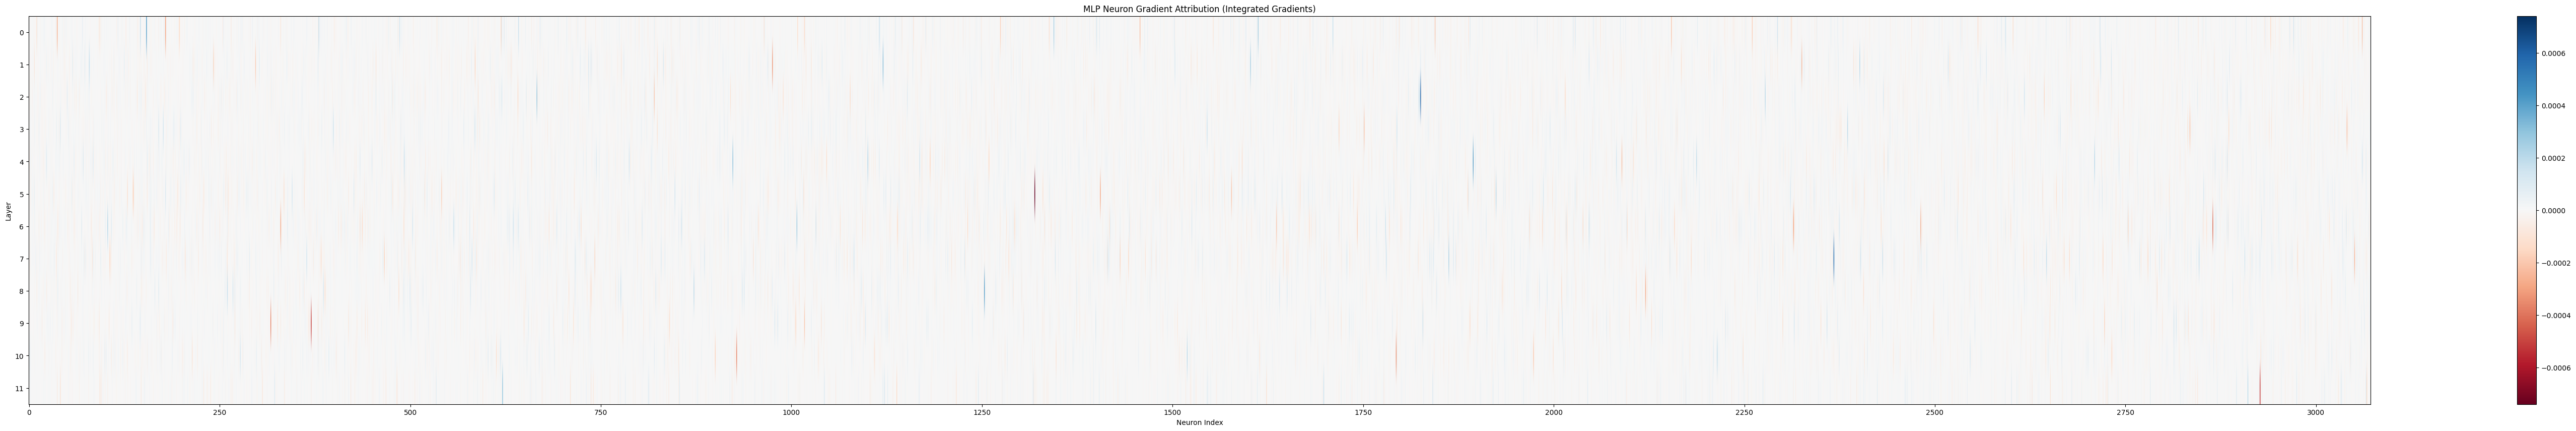

In [7]:
bound = max(torch.max(mlp_ig_zero_results), abs(torch.min(mlp_ig_zero_results)))

plt.figure(figsize=(75, 10))
plt.imshow(mlp_ig_zero_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound, aspect="auto")
plt.title("MLP Neuron Gradient Attribution (Integrated Gradients)")
plt.xticks(np.arange(0, model.cfg.d_mlp, 250))
plt.xlabel("Neuron Index")
plt.yticks(list(range(model.cfg.n_layers)))
plt.ylabel("Layer")
plt.colorbar()
plt.show()

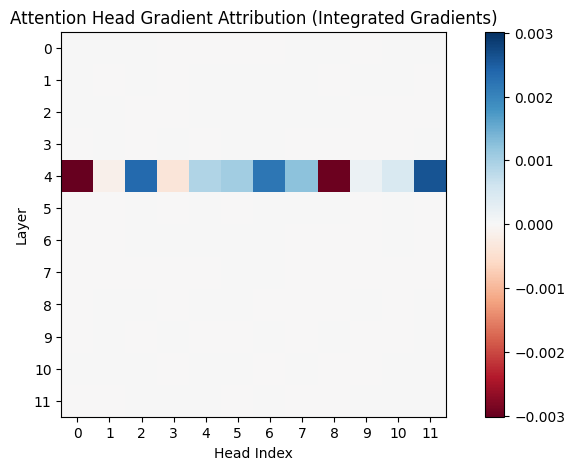

In [8]:
bound = max(torch.max(attn_ig_zero_results), abs(torch.min(attn_ig_zero_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_ig_zero_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Gradient Attribution (Integrated Gradients)")

plt.xlabel("Head Index")
plt.xticks(list(range(model.cfg.n_heads)))

plt.ylabel("Layer")
plt.yticks(list(range(model.cfg.n_layers)))

plt.colorbar()
plt.show()

## Activation Patching

In [9]:
def patch_neuron_hook(activations: torch.Tensor, hook: HookPoint, cache: ActivationCache, neuron_idx: int):
    # Replace the activations for the target neuron with activations from the cached run.
    cached_activations = cache[hook.name]
    activations[:, :, neuron_idx] = cached_activations[:, :, neuron_idx]
    return activations

def patch_attn_hook(activations: torch.Tensor, hook: HookPoint, cache: ActivationCache, head_idx: int):
    # Replace the activations for the target attention head with activations from the cached run.
    cached_activations = cache[hook.name]
    activations[:, :, head_idx, :] = cached_activations[:, :, head_idx, :]
    return activations

In [10]:
mlp_patch_results = torch.load("mlp_patch_results.pt")
attn_patch_results = torch.load("attn_patch_results.pt")

In [ ]:
baseline_diff = (clean_logit_diff - corrupted_logit_diff).item()

class StopExecution(Exception):
    def _render_traceback_(self):
        return []
    
# Check if we have run activation patching already (expensive)
try:
    mlp_patch_results = torch.load("mlp_patch_results.pt")
    attn_patch_results = torch.load("attn_patch_results.pt")
    raise StopExecution
except FileNotFoundError:
    mlp_patch_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
    attn_patch_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

    for layer in range(model.cfg.n_layers):
        # Activation patching on heads
        for head in range(model.cfg.n_heads):
            hook_name = get_act_name("result", layer)
            temp_hook = lambda act, hook: patch_attn_hook(act, hook, corrupted_cache, head)

            with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
                patched_logits = model(clean_input)

            patched_logit_diff = logits_to_logit_diff(patched_logits).detach()
            # Normalise result by clean and corrupted logit difference
            attn_patch_results[layer, head] = (patched_logit_diff - clean_logit_diff) / baseline_diff

        # Activation patching on MLP neurons
        for neuron in range(model.cfg.d_mlp):
            hook_name = get_act_name("post", layer)
            temp_hook = lambda act, hook: patch_neuron_hook(act, hook, corrupted_cache, neuron)
            
            with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
                patched_logits = model(clean_input)

            patched_logit_diff = logits_to_logit_diff(patched_logits).detach()
            # Normalise result by clean and corrupted logit difference
            mlp_patch_results[layer, neuron] = (patched_logit_diff - clean_logit_diff) / baseline_diff
    
    torch.save(mlp_patch_results, "mlp_patch_results.pt")
    torch.save(attn_patch_results, "attn_patch_results.pt")

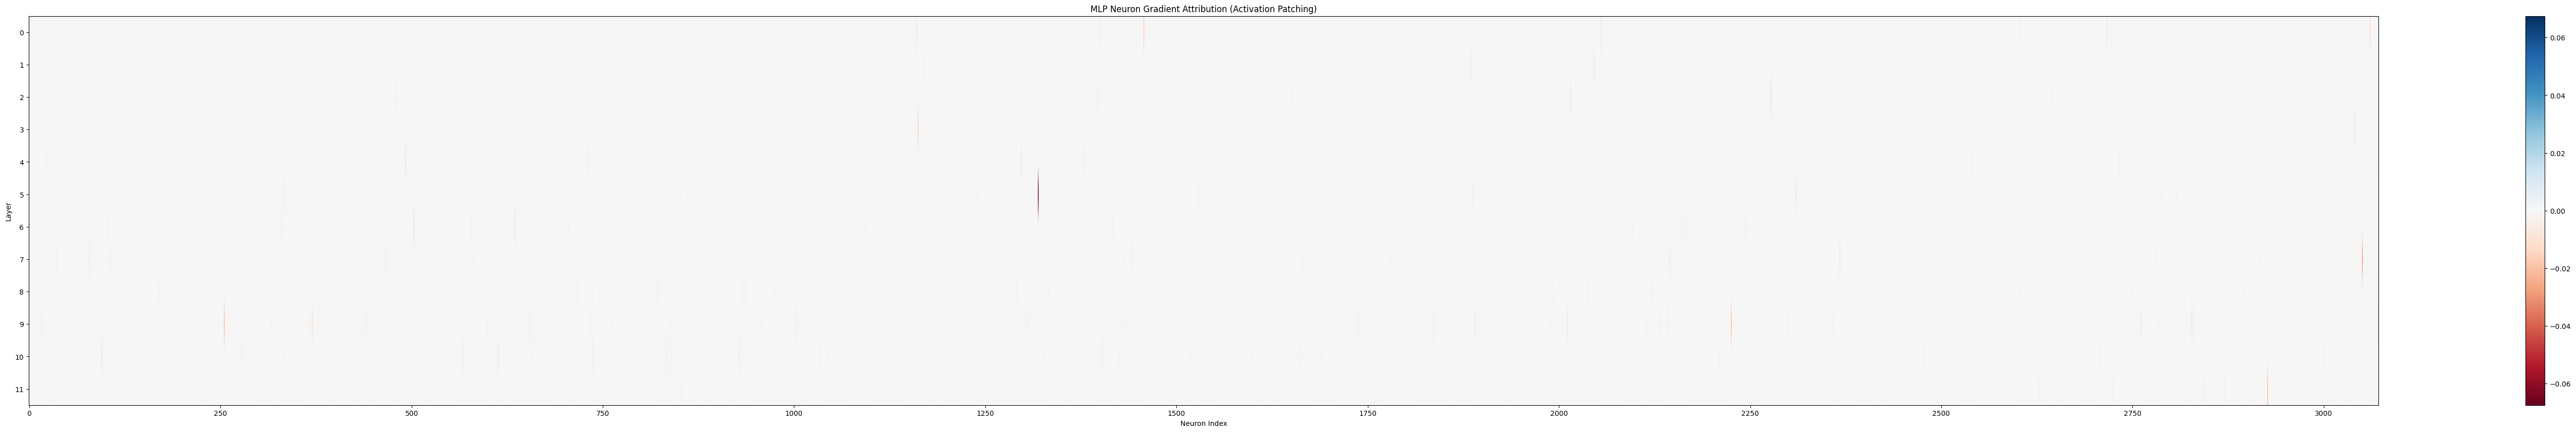

In [11]:
bound = max(torch.max(mlp_patch_results), abs(torch.min(mlp_patch_results)))

plt.figure(figsize=(75, 10))
plt.imshow(mlp_patch_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound, aspect="auto")
plt.title("MLP Neuron Gradient Attribution (Activation Patching)")
plt.xticks(np.arange(0, model.cfg.d_mlp, 250))
plt.xlabel("Neuron Index")
plt.yticks(list(range(model.cfg.n_layers)))
plt.ylabel("Layer")
plt.colorbar()
plt.show()

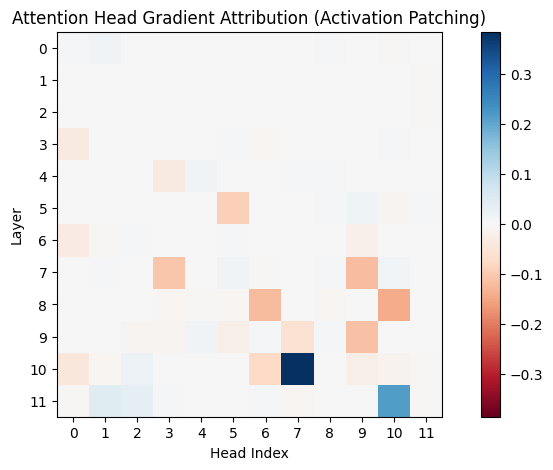

In [12]:
bound = max(torch.max(attn_patch_results), abs(torch.min(attn_patch_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_patch_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Gradient Attribution (Activation Patching)")

plt.xlabel("Head Index")
plt.xticks(list(range(model.cfg.n_heads)))

plt.ylabel("Layer")
plt.yticks(list(range(model.cfg.n_layers)))

plt.colorbar()
plt.show()

## Analysis of initial attribution methods

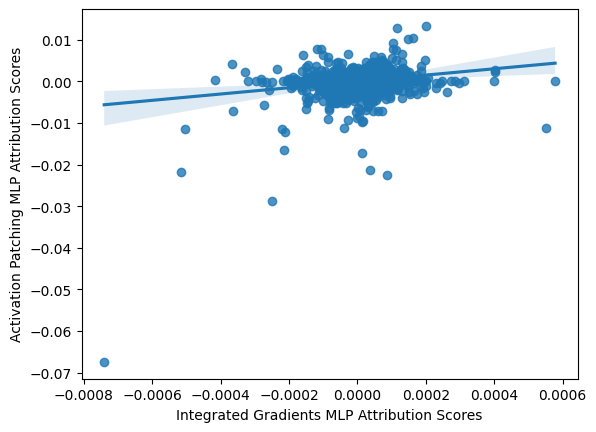

Correlation coefficient between IG and AP attributions for neurons: 0.2350942982779252


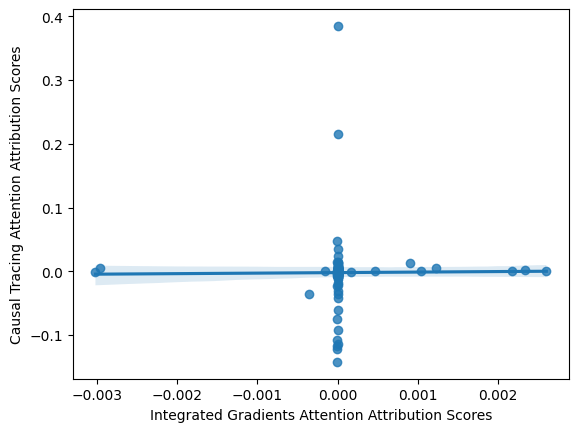

Correlation coefficient between IG and AP attributions for attention: 0.00930087754303134


In [13]:
# Plot the attribution scores against each other. Correlation: y = x.

x = mlp_ig_zero_results.flatten().numpy()
y = mlp_patch_results.flatten().numpy()

sns.regplot(x=x, y=y)
plt.xlabel("Integrated Gradients MLP Attribution Scores")
plt.ylabel("Activation Patching MLP Attribution Scores")
plt.show()

print(f"Correlation coefficient between IG and AP attributions for neurons: {np.corrcoef(x, y)[0, 1]}")

x = attn_ig_zero_results.flatten().numpy()
y = attn_patch_results.flatten().numpy()

sns.regplot(x=x, y=y)
plt.xlabel("Integrated Gradients Attention Attribution Scores")
plt.ylabel("Causal Tracing Attention Attribution Scores")
plt.show()

print(f"Correlation coefficient between IG and AP attributions for attention: {np.corrcoef(x, y)[0, 1]}")

In [14]:
def get_top_k_by_abs(data, k):
    _, indices = torch.topk(data.flatten().abs(), k)
    top_k_values = torch.gather(data.flatten(), 0, indices)
    formatted_indices = []
    for idx in indices:
        layer = idx // model.cfg.d_mlp
        neuron_pos = idx % model.cfg.d_mlp
        formatted_indices.append([layer, neuron_pos])
    return torch.tensor(formatted_indices), top_k_values

def get_attributions_above_threshold(data, percentile):
    threshold = torch.min(data) + percentile * (torch.max(data) - torch.min(data))
    masked_data = torch.where(data > threshold, data, 0)
    nonzero_indices = torch.nonzero(masked_data)
    return nonzero_indices, masked_data

top_mlp_ig_zero_indices, top_mlp_ig_zero_results = get_top_k_by_abs(mlp_ig_zero_results, 30)
top_mlp_patch_indices, top_mlp_patch_results = get_top_k_by_abs(mlp_patch_results, 30)

top_mlp_ig_zero_sets = set([tuple(t.tolist()) for t in top_mlp_ig_zero_indices])
top_mlp_patch_sets = set([tuple(t.tolist()) for t in top_mlp_patch_indices])

intersection = top_mlp_ig_zero_sets.intersection(top_mlp_patch_sets)
union = top_mlp_ig_zero_sets.union(top_mlp_patch_sets)
jaccard = len(intersection) / len(union)

print(f"Jaccard score for MLP neurons: {jaccard}")

Jaccard score for MLP neurons: 0.1111111111111111


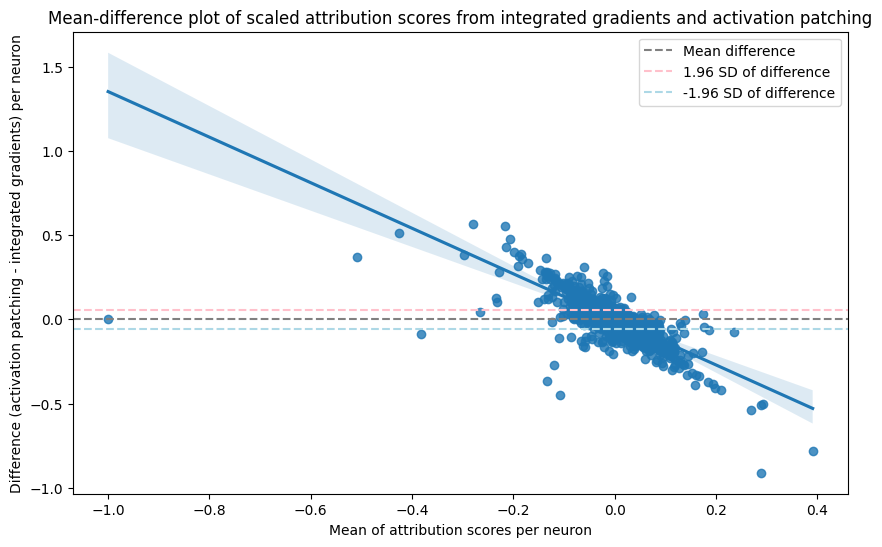

In [15]:
from sklearn.preprocessing import MaxAbsScaler

mlp_ig_zero_results_1d = mlp_ig_zero_results.flatten().numpy()
mlp_patch_results_1d = mlp_patch_results.flatten().numpy()

# Mean difference plot with scaled data

scaled_mlp_ig_results_1d = MaxAbsScaler().fit_transform(mlp_ig_zero_results_1d.reshape(-1, 1))
scaled_mlp_patch_results_1d = MaxAbsScaler().fit_transform(mlp_patch_results_1d.reshape(-1, 1))

mean = np.mean([scaled_mlp_ig_results_1d, scaled_mlp_patch_results_1d], axis=0)
diff = scaled_mlp_patch_results_1d - scaled_mlp_ig_results_1d
md = np.mean(diff) # Mean of the difference
sd = np.std(diff, axis=0) # Standard deviation of the difference

plt.figure(figsize=(10, 6))
sns.regplot(x=mean, y=diff, fit_reg=True, scatter=True)
plt.axhline(md, color='gray', linestyle='--', label="Mean difference")
plt.axhline(md + 1.96*sd, color='pink', linestyle='--', label="1.96 SD of difference")
plt.axhline(md - 1.96*sd, color='lightblue', linestyle='--', label="-1.96 SD of difference")
plt.xlabel("Mean of attribution scores per neuron")
plt.ylabel("Difference (activation patching - integrated gradients) per neuron")
plt.title("Mean-difference plot of scaled attribution scores from integrated gradients and activation patching")
plt.legend()
plt.show()

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

scaled_attn_ig_zero_results = MaxAbsScaler().fit_transform(attn_ig_zero_results)
scaled_attn_patch_results = MaxAbsScaler().fit_transform(attn_patch_results)

diff_attn_results = scaled_attn_ig_zero_results - scaled_attn_patch_results
diff_attn_results_abs = np.abs(scaled_attn_ig_zero_results) - np.abs(scaled_attn_patch_results)

plt.subplot(1, 2, 1)
plt.imshow(diff_attn_results, cmap="RdBu")
plt.title("Difference in attributions for attention heads")

plt.xlabel("Head Index")
plt.xticks(list(range(model.cfg.n_heads)))

plt.ylabel("Layer")
plt.yticks(list(range(model.cfg.n_layers)))

plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(diff_attn_results_abs, cmap="RdBu")
plt.title("Difference in (absolute) attributions for attention heads")

plt.xlabel("Head Index")
plt.xticks(list(range(model.cfg.n_heads)))

plt.ylabel("Layer")
plt.yticks(list(range(model.cfg.n_layers)))

plt.colorbar()
plt.tight_layout()
plt.show()

# Comparable baselines

*Hypothesis*: One possible reason for the discrepancy between patching and IG is that the range of activations tested may be from different distributions.

Both gradient methods rely on counterfactual reasoning. IG computes the integral between some baseline (which produces zero output) and given input, whereas causal tracing computes the logit difference between two counterfactual inputs. If the counterfactuals used are different, then this could cause a discrepancy.

To evaluate this hypothesis, we compute IG and AP on GPT2-Small with the same counterfactual inputs.

In [16]:
# Gradient attribution for neurons in MLP layers
mlp_ig_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
# Gradient attribution for attention heads
attn_ig_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

# Calculate integrated gradients for each layer
for layer in range(model.cfg.n_layers):
    # Gradient attribution on heads
    hook_name = get_act_name("result", layer)
    target_layer = model.hook_dict[hook_name]
    prev_layer_hook = get_act_name("z", layer)
    prev_layer = model.hook_dict[prev_layer_hook]

    layer_clean_input = clean_cache[prev_layer_hook]
    layer_corrupt_input = corrupted_cache[prev_layer_hook]

    attributions = compute_layer_to_output_attributions(clean_input, layer_corrupt_input, layer_clean_input, target_layer, prev_layer) # shape [1, seq_len, d_head, d_model]
    # Calculate attribution score based on mean over each embedding, for each token
    print(attributions.shape)
    per_token_score = attributions.mean(dim=3)
    score = per_token_score.mean(dim=1)
    attn_ig_results[layer] = score

    # Gradient attribution on MLP neurons
    hook_name = get_act_name("post", layer)
    target_layer = model.hook_dict[hook_name]
    prev_layer_hook = get_act_name("mlp_in", layer)
    prev_layer = model.hook_dict[prev_layer_hook]

    layer_clean_input = clean_cache[prev_layer_hook]
    layer_corrupt_input = corrupted_cache[prev_layer_hook]
    
    attributions = compute_layer_to_output_attributions(clean_input, layer_corrupt_input, layer_clean_input, target_layer, prev_layer) # shape [1, seq_len, d_model]
    print(attributions.shape)
    score = attributions.mean(dim=1)
    mlp_ig_results[layer] = score


Error (delta) for blocks.0.attn.hook_result attribution: -0.08010423183441162
torch.Size([1, 17, 12, 768])

Error (delta) for blocks.0.mlp.hook_post attribution: 5.367663860321045
torch.Size([1, 17, 3072])

Error (delta) for blocks.1.attn.hook_result attribution: 0.05616430938243866
torch.Size([1, 17, 12, 768])

Error (delta) for blocks.1.mlp.hook_post attribution: -0.10697655379772186
torch.Size([1, 17, 3072])

Error (delta) for blocks.2.attn.hook_result attribution: -0.012761879712343216
torch.Size([1, 17, 12, 768])

Error (delta) for blocks.2.mlp.hook_post attribution: -0.11945552378892899
torch.Size([1, 17, 3072])

Error (delta) for blocks.3.attn.hook_result attribution: 0.2565889358520508
torch.Size([1, 17, 12, 768])

Error (delta) for blocks.3.mlp.hook_post attribution: 0.1360594630241394
torch.Size([1, 17, 3072])

Error (delta) for blocks.4.attn.hook_result attribution: 0.051070213317871094
torch.Size([1, 17, 12, 768])

Error (delta) for blocks.4.mlp.hook_post attribution: -0.0

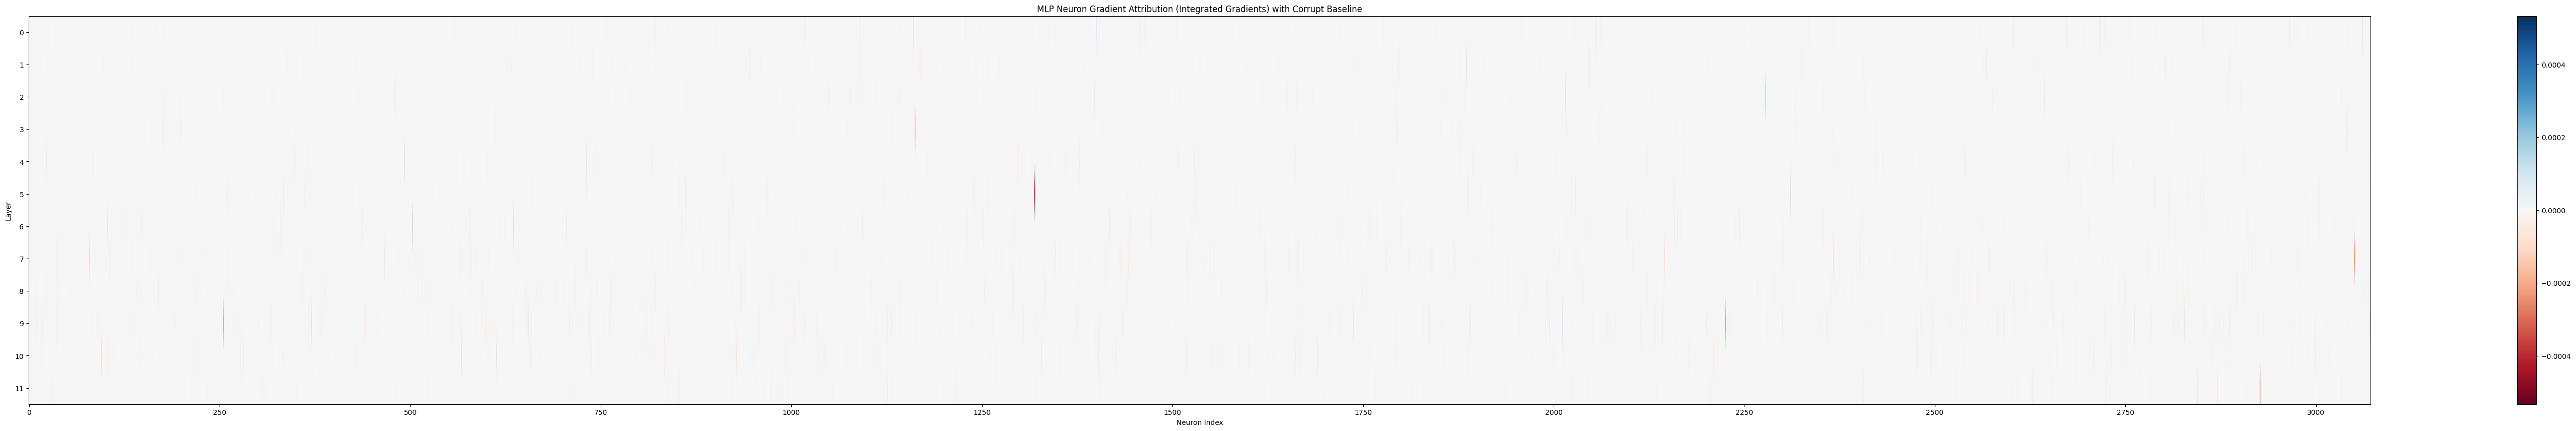

In [17]:
bound = max(torch.max(mlp_ig_results), abs(torch.min(mlp_ig_results)))

plt.figure(figsize=(75, 10))
plt.imshow(mlp_ig_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound, aspect="auto")
plt.title("MLP Neuron Gradient Attribution (Integrated Gradients) with Corrupt Baseline")
plt.xticks(np.arange(0, model.cfg.d_mlp, 250))
plt.xlabel("Neuron Index")
plt.yticks(list(range(model.cfg.n_layers)))
plt.ylabel("Layer")
plt.colorbar()
plt.show()

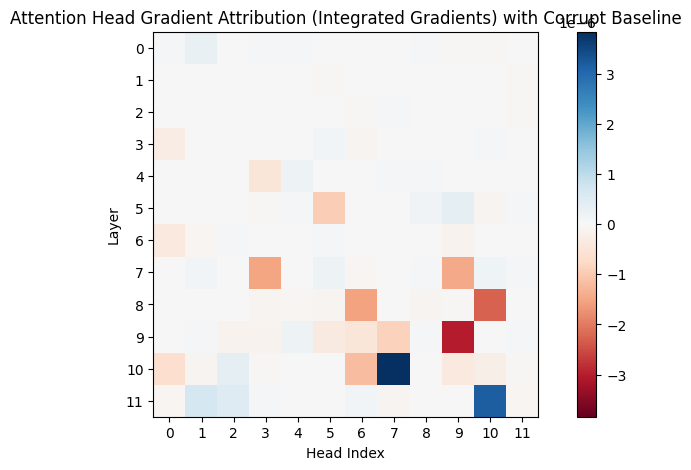

In [18]:
bound = max(torch.max(attn_ig_results), abs(torch.min(attn_ig_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_ig_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Gradient Attribution (Integrated Gradients) with Corrupt Baseline")

plt.xlabel("Head Index")
plt.xticks(list(range(model.cfg.n_heads)))

plt.ylabel("Layer")
plt.yticks(list(range(model.cfg.n_layers)))

plt.colorbar()
plt.show()

## Analysis of comparable baselines

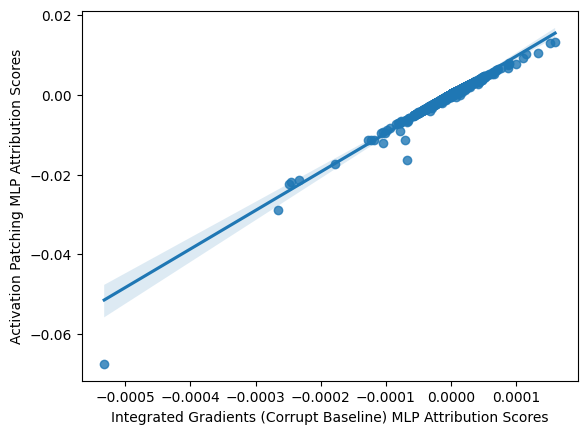

Correlation coefficient between IG with corrupted baseline and AP attributions for neurons: 0.9852227509307566


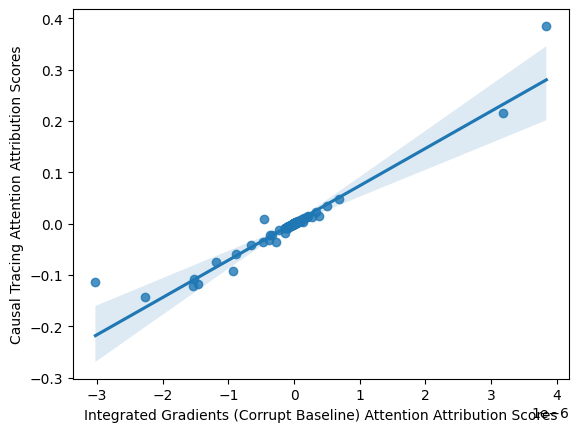

Correlation coefficient between IG with corrupted baseline and AP attributions for attention: 0.9547628738711134


In [19]:
# Plot the attribution scores against each other. Correlation: y = x.

x = mlp_ig_results.flatten().numpy()
y = mlp_patch_results.flatten().numpy()

sns.regplot(x=x, y=y)
plt.xlabel("Integrated Gradients (Corrupt Baseline) MLP Attribution Scores")
plt.ylabel("Activation Patching MLP Attribution Scores")
plt.show()

print(f"Correlation coefficient between IG with corrupted baseline and AP attributions for neurons: {np.corrcoef(x, y)[0, 1]}")

x = attn_ig_results.flatten().numpy()
y = attn_patch_results.flatten().numpy()

sns.regplot(x=x, y=y)
plt.xlabel("Integrated Gradients (Corrupt Baseline) Attention Attribution Scores")
plt.ylabel("Causal Tracing Attention Attribution Scores")
plt.show()

print(f"Correlation coefficient between IG with corrupted baseline and AP attributions for attention: {np.corrcoef(x, y)[0, 1]}")

In [20]:
def get_top_k_by_abs(data, k):
    _, indices = torch.topk(data.flatten().abs(), k)
    top_k_values = torch.gather(data.flatten(), 0, indices)
    formatted_indices = []
    for idx in indices:
        layer = idx // model.cfg.d_mlp
        neuron_pos = idx % model.cfg.d_mlp
        formatted_indices.append([layer, neuron_pos])
    return torch.tensor(formatted_indices), top_k_values

def get_attributions_above_threshold(data, percentile):
    threshold = torch.min(data) + percentile * (torch.max(data) - torch.min(data))
    masked_data = torch.where(data > threshold, data, 0)
    nonzero_indices = torch.nonzero(masked_data)
    return nonzero_indices, masked_data

top_mlp_ig_indices, top_mlp_ig_results = get_top_k_by_abs(mlp_ig_results, 30)
top_mlp_patch_indices, top_mlp_patch_results = get_top_k_by_abs(mlp_patch_results, 30)

top_mlp_ig_sets = set([tuple(t.tolist()) for t in top_mlp_ig_indices])
top_mlp_patch_sets = set([tuple(t.tolist()) for t in top_mlp_patch_indices])

intersection = top_mlp_ig_sets.intersection(top_mlp_patch_sets)
union = top_mlp_ig_sets.union(top_mlp_patch_sets)
jaccard = len(intersection) / len(union)

print(f"Jaccard score for MLP neurons: {jaccard}")

Jaccard score for MLP neurons: 0.875


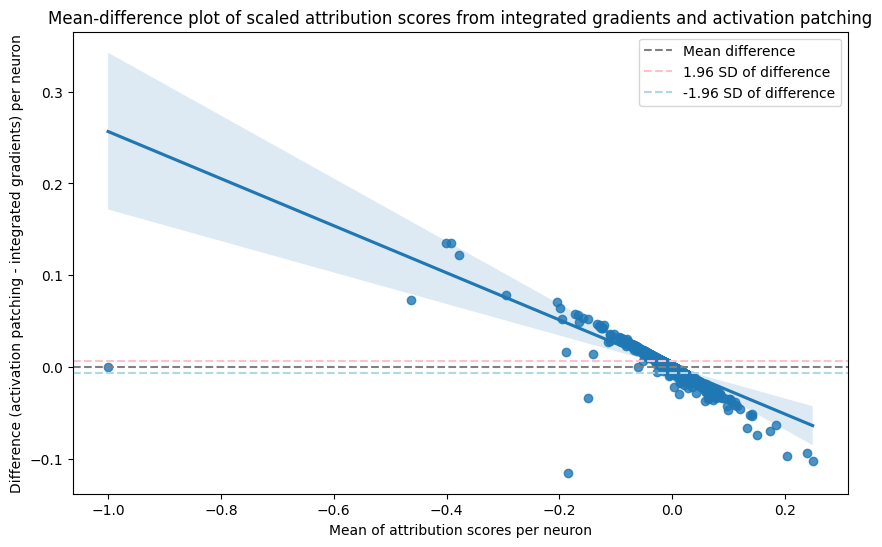

In [21]:
from sklearn.preprocessing import MaxAbsScaler

mlp_ig_results_1d = mlp_ig_results.flatten().numpy()
mlp_patch_results_1d = mlp_patch_results.flatten().numpy()

# Mean difference plot with scaled data

scaled_mlp_ig_results_1d = MaxAbsScaler().fit_transform(mlp_ig_results_1d.reshape(-1, 1))
scaled_mlp_patch_results_1d = MaxAbsScaler().fit_transform(mlp_patch_results_1d.reshape(-1, 1))

mean = np.mean([scaled_mlp_ig_results_1d, scaled_mlp_patch_results_1d], axis=0)
diff = scaled_mlp_patch_results_1d - scaled_mlp_ig_results_1d
md = np.mean(diff) # Mean of the difference
sd = np.std(diff, axis=0) # Standard deviation of the difference

plt.figure(figsize=(10, 6))
sns.regplot(x=mean, y=diff, fit_reg=True, scatter=True)
plt.axhline(md, color='gray', linestyle='--', label="Mean difference")
plt.axhline(md + 1.96*sd, color='pink', linestyle='--', label="1.96 SD of difference")
plt.axhline(md - 1.96*sd, color='lightblue', linestyle='--', label="-1.96 SD of difference")
plt.xlabel("Mean of attribution scores per neuron")
plt.ylabel("Difference (activation patching - integrated gradients) per neuron")
plt.title("Mean-difference plot of scaled attribution scores from integrated gradients and activation patching")
plt.legend()
plt.show()

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

scaled_attn_ig_results = MaxAbsScaler().fit_transform(attn_ig_results)
scaled_attn_patch_results = MaxAbsScaler().fit_transform(attn_patch_results)

diff_attn_results = scaled_attn_ig_results - scaled_attn_patch_results
diff_attn_results_abs = np.abs(scaled_attn_ig_results) - np.abs(scaled_attn_patch_results)

plt.subplot(1, 2, 1)
plt.imshow(diff_attn_results, cmap="RdBu")
plt.title("Difference in attributions for attention heads")

plt.xlabel("Head Index")
plt.xticks(list(range(model.cfg.n_heads)))

plt.ylabel("Layer")
plt.yticks(list(range(model.cfg.n_layers)))

plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(diff_attn_results_abs, cmap="RdBu")
plt.title("Difference in (absolute) attributions for attention heads")

plt.xlabel("Head Index")
plt.xticks(list(range(model.cfg.n_heads)))

plt.ylabel("Layer")
plt.yticks(list(range(model.cfg.n_layers)))

plt.colorbar()
plt.tight_layout()
plt.show()